# SIT742 Task 2

### Student IDs - **s224057178**, **s...**, **224627753**
### Student Names - **Bravine Cheruiyot**, **Keshani Attanayake**, **Shevan Michael**

## Part I


## Question 1.1

In [3]:
from pyspark.sql import SparkSession
from google.colab import files

#Creating the Spark session
spark = SparkSession.builder \
    .appName("Assignment2") \
    .getOrCreate()

uploaded = files.upload()

#Reading review.csv
reviews_df = spark.read.option("header", True) \
                       .option("inferSchema", True) \
                       .option("multiLine", True) \
                       .option("escape", "\"") \
                       .option("quote", "\"") \
                       .csv("review.csv")

Saving review.csv to review.csv


In [4]:
# 1.1.1

from pyspark.sql.functions import col, when

#Replacing null rows with "no review" in the 'text' column
reviews_df = reviews_df.withColumn(
    "text",
    when(col("text").isNull(), "no review").otherwise(col("text"))
)

In [5]:
# 1.1.2

from pyspark.sql.functions import from_unixtime, col

#Converting the 'time' column into the required format
reviews_df = reviews_df.withColumn("newtime", from_unixtime(col("time"), "yyyy-MM-dd"))

#Printing results
reviews_df.select("time", "newtime").show(5, truncate=False)

+----------+------------+
|time      |newtime     |
+----------+------------+
|1.56633E12|+51605-01-08|
|1.50492E12|+49659-01-06|
|1.47477E12|+48703-08-09|
|1.47286E12|+48643-01-28|
|1.52965E12|+50442-09-05|
+----------+------------+
only showing top 5 rows



## Question 1.2

In [6]:
# 1.2.1

from pyspark.sql.functions import count

#Counting the reviews for every unique gmap_id
review_counts_df = reviews_df.groupBy("gmap_id").agg(count("*").cast("float").alias("review_count"))

#Printing results
review_counts_df.show(5, truncate=False)

+-------------------------------------+------------+
|gmap_id                              |review_count|
+-------------------------------------+------------+
|0x56c8977642a793f5:0xab9f95aa9c585a46|27.0        |
|0x56c79c63a5af15e3:0x117ca44b9578b995|10.0        |
|0x56c8976e16705e63:0x787e5d94ea9d2387|49.0        |
|0x51325aac7a4434e5:0xfbed5197982b41ae|28.0        |
|0x56c6631e32190947:0x7620b39117ffbb62|12.0        |
+-------------------------------------+------------+
only showing top 5 rows



In [7]:
# 1.2.2

#Converting to a pandas df
df = reviews_df.toPandas()

import pandas as pd
from datetime import datetime

df['time'] = df['time'].astype(float)

#Converting from milliseconds to seconds first before getting the hours to avoid errors
df['review_time'] = df['time'].apply(
    lambda x: datetime.fromtimestamp(x/1000).hour if not pd.isnull(x) else None
)

#Printing results
df[['time', 'review_time']].head()

,time,review_time
0,1.566330e+12,19
1,1.504920e+12,1
2,1.474770e+12,2
3,1.472860e+12,23
4,1.529650e+12,6


/tmp/ipython-input-340486209.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='review_time', data=df, palette='viridis')


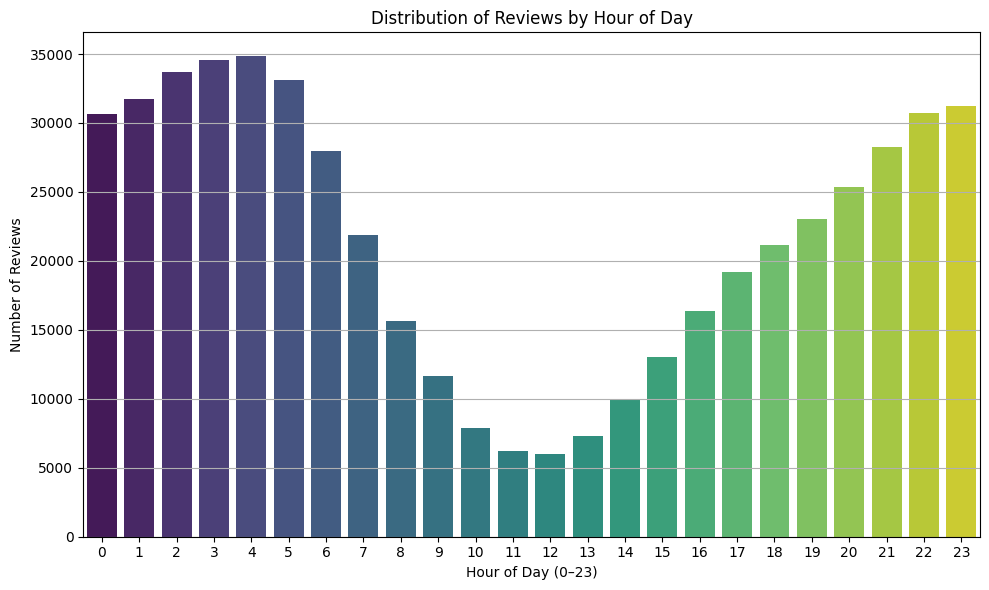

In [8]:
# 1.2.3

import matplotlib.pyplot as plt
import seaborn as sns

#Considering what time people make reviews
plt.figure(figsize=(10, 6))
sns.countplot(x='review_time', data=df, palette='viridis')
plt.title('Distribution of Reviews by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

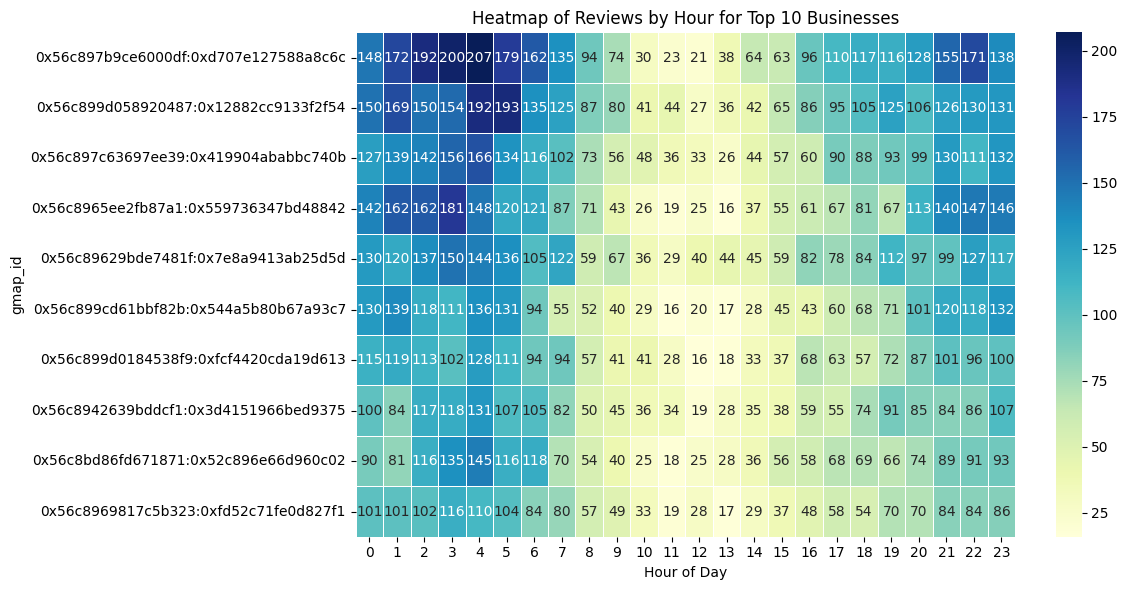

In [9]:
#Creating a pivot table
pivot_table = df.pivot_table(index='gmap_id', columns='review_time', aggfunc='size', fill_value=0)

#The businesses (top 10) with the most number of reviews
top_10_gmap = df['gmap_id'].value_counts().nlargest(10).index
pivot_top_10 = pivot_table.loc[top_10_gmap]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_top_10, cmap='YlGnBu', linewidths=0.5, annot=True, fmt='d')
plt.title('Heatmap of Reviews by Hour for Top 10 Businesses')
plt.xlabel('Hour of Day')
plt.ylabel('gmap_id')
plt.tight_layout()
plt.show()

Most of the reviews are made from 3 to 5 am. In the afternoon, there is massive drop in the number of reviews and this starts to increase only after about 12pm. Based on this, we can see that people leave reviews either early in the morning or in the evening.

## Question 1.3

In [10]:
# Set up for 1.3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

#Reading meta-review-business.csv
uploaded = files.upload()
meta_df = spark.read.option("header", True) \
                       .option("inferSchema", True) \
                       .option("multiLine", True) \
                       .option("escape", "\"") \
                       .option("quote", "\"") \
                       .csv("meta-review-business.csv")

# Ensuring Pandas DataFrames
meta_p = meta_df.toPandas() if hasattr(meta_df, "toPandas") else meta_df.copy()
df_p   = df.toPandas()       if hasattr(df, "toPandas")   else df.copy()

# Normalise/validate key columns
# reviews
if "gmap_id" not in df_p.columns:
    raise KeyError("Expected 'gmap_id' in reviews dataframe.")

# time column can be 'time' or 'review_time'
time_col = "time" if "time" in df_p.columns else ("review_time" if "review_time" in df_p.columns else None)
if time_col is None:
    raise KeyError("Expected a time column named 'time' or 'review_time' in reviews dataframe.")

# rating column
rating_col = "rating" if "rating" in df_p.columns else (
    "stars" if "stars" in df_p.columns else ("score" if "score" in df_p.columns else None)
)
if rating_col is None:
    raise KeyError("Expected a rating column named 'rating' (or 'stars'/'score').")

# meta — renaming to consistent names
if "name" in meta_p.columns and "business_name" not in meta_p.columns:
    meta_p = meta_p.rename(columns={"name": "business_name"})
if "categories" in meta_p.columns and "category" not in meta_p.columns:
    meta_p = meta_p.rename(columns={"categories": "category"})

for col in ["business_name", "category"]:
    if col not in meta_p.columns:
        meta_p[col] = pd.NA

# Robust time parsing -> review_time, day_of_week, hour
t_num = pd.to_numeric(df_p[time_col], errors="coerce")
if t_num.notna().mean() > 0.8:               # mostly numeric epochs
    med = t_num.median()
    if med > 1e12:                            # milliseconds
        rt = pd.to_datetime(t_num, unit="ms", origin="unix", utc=True)
    elif med > 1e9:                           # seconds
        rt = pd.to_datetime(t_num, unit="s", origin="unix", utc=True)
    else:                                     # unlikely epoch; fallback
        rt = pd.to_datetime(df_p[time_col], errors="coerce", utc=True)
else:
    rt = pd.to_datetime(df_p[time_col], errors="coerce", utc=True)

df_p["review_time"] = rt.dt.tz_convert(None)
df_p["day_of_week"] = df_p["review_time"].dt.day_name()
df_p["hour"]        = df_p["review_time"].dt.hour

# 3) Join review data with meta on gmap_id
df_with_meta = df_p.merge(meta_p, on="gmap_id", how="left")

print(f"DataFrame with meta data shape: {df_with_meta.shape}")
print("\n=== Sample of joined data ===")
sample_cols = [c for c in ["gmap_id","business_name","category","day_of_week","review_time","rating"] if c in df_with_meta.columns]
print(df_with_meta[sample_cols].head())

Saving meta-review-business.csv to meta-review-business.csv
DataFrame with meta data shape: (521997, 26)

=== Sample of joined data ===
                                 gmap_id                business_name  \
0  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
1  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
2  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
3  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
4  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   

                                           category day_of_week  \
0  ['RV park', 'Cabin rental agency', 'Campground']     Tuesday   
1  ['RV park', 'Cabin rental agency', 'Campground']     Tuesday   
2  ['RV park', 'Cabin rental agency', 'Campground']    Saturday   
3  ['RV park', 'Cabin rental agency', 'Campground']    Saturday   
4  ['RV park', 'Cabin rental agency', 'Campground']      Sunday   

          review_time 


=== Average Reviews by Day of Week ===
  day_of_week  review_count  avg_reviews
6      Sunday         80016   175.859341
5    Saturday         78239   168.618534
2   Wednesday         74031   164.148559
3    Thursday         73363   163.391982
0      Monday         72430   160.955556
1     Tuesday         72444   159.217582
4      Friday         71474   155.041215


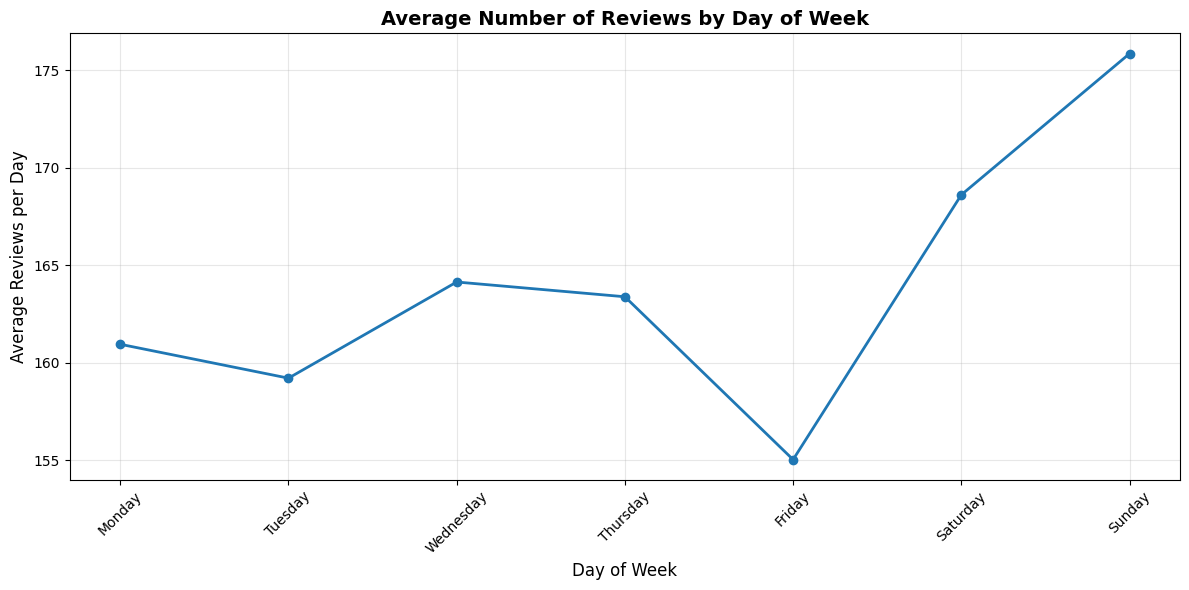


Day with most average reviews: Sunday (175.86 reviews per day)


In [11]:
# 1.3.1 — Determine which workday generates the most reviews
workday_reviews = (
    df_with_meta.groupby("day_of_week")
                .size()
                .reset_index(name="review_count")
)

# average daily submissions per weekday:
# group by (weekday, calendar date) -> count -> mean per weekday
workday_avg = (
    df_with_meta.groupby(["day_of_week", df_with_meta["review_time"].dt.date])
                .size()
                .groupby(level=0)
                .mean()
                .reset_index(name="avg_reviews")
)

# Merge and order for plotting
workday_analysis = workday_reviews.merge(workday_avg, on="day_of_week")
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
workday_analysis["day_of_week"] = pd.Categorical(workday_analysis["day_of_week"], categories=day_order, ordered=True)
workday_analysis = workday_analysis.sort_values("day_of_week").reset_index(drop=True)

print("\n=== Average Reviews by Day of Week ===")
print(workday_analysis.sort_values("avg_reviews", ascending=False))

# Line chart (no explicit colors/styles)
plt.figure(figsize=(12, 6))
plt.plot(workday_analysis["day_of_week"], workday_analysis["avg_reviews"], marker="o", linewidth=2)
plt.title("Average Number of Reviews by Day of Week", fontsize=14, fontweight="bold")
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Reviews per Day", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Peak day by average reviews
peak_idx = workday_analysis["avg_reviews"].idxmax()
peak_day = workday_analysis.loc[peak_idx, "day_of_week"]
peak_avg = workday_analysis.loc[peak_idx, "avg_reviews"]
print(f"\nDay with most average reviews: {peak_day} ({peak_avg:.2f} reviews per day)")

In [12]:
# 1.3.2 — Highest average ratings on that peak day
# (with business names & categories)
peak_day_data = df_with_meta[df_with_meta["day_of_week"] == peak_day].copy()
peak_day_data["rating"] = pd.to_numeric(peak_day_data[rating_col], errors="coerce")

peak_day_ratings = (
    peak_day_data.groupby(["business_name","category"])
                 .agg(avg_rating=("rating","mean"),
                      review_count=("gmap_id","size"))
                 .reset_index()
)

# Reliability threshold (set to >=2)
MIN_REVIEWS = 2
reliable_businesses = (
    peak_day_ratings[peak_day_ratings["review_count"] >= MIN_REVIEWS]
    .sort_values(["avg_rating","review_count"], ascending=[False, False])
    .reset_index(drop=True)
)

print(f"\n=== Top Businesses with Highest Ratings on {peak_day} (≥{MIN_REVIEWS} reviews) ===")
print(reliable_businesses.head(10))

if not reliable_businesses.empty:
    top_business = reliable_businesses.iloc[0]
    print(f"\nHighest rated business on {peak_day}: {top_business['business_name']}")
    print(f"Category: {top_business['category']}")
    print(f"Average Rating: {top_business['avg_rating']:.2f}")
    print(f"Number of Reviews: {top_business['review_count']}")

    # Categories represented among top 10
    top_categories = reliable_businesses.head(10)["category"].value_counts(dropna=True)
    print(f"\n=== Categories of Top 10 Highest-Rated Businesses on {peak_day} ===")
    print(top_categories)
else:
    print("\nNo businesses meet the minimum review threshold on the peak day.")


=== Top Businesses with Highest Ratings on Sunday (≥2 reviews) ===
                                       business_name  \
0                                   Escape Anchorage   
1  Winner Creek Gorge Trail Head (Lower Winner Cr...   
2                           Alaska Veterinary Clinic   
3                             Anchorage Ace Hardware   
4                                  Black Birch Books   
5                                Lucky Raven Tobacco   
6  Midnight Market | Vape And Smoke Shop In Ancho...   
7                             Bleeding Heart Brewery   
8                        Granite View Sports & gifts   
9            Independence Mine State Historical Park   

                                            category  avg_rating  review_count  
0              ['Escape room center', 'Entertainer']         5.0            20  
1              ['Hiking area', 'Tourist attraction']         5.0            15  
2            ['Veterinarian', 'Veterinary pharmacy']         5.0        

/tmp/ipython-input-183176935.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


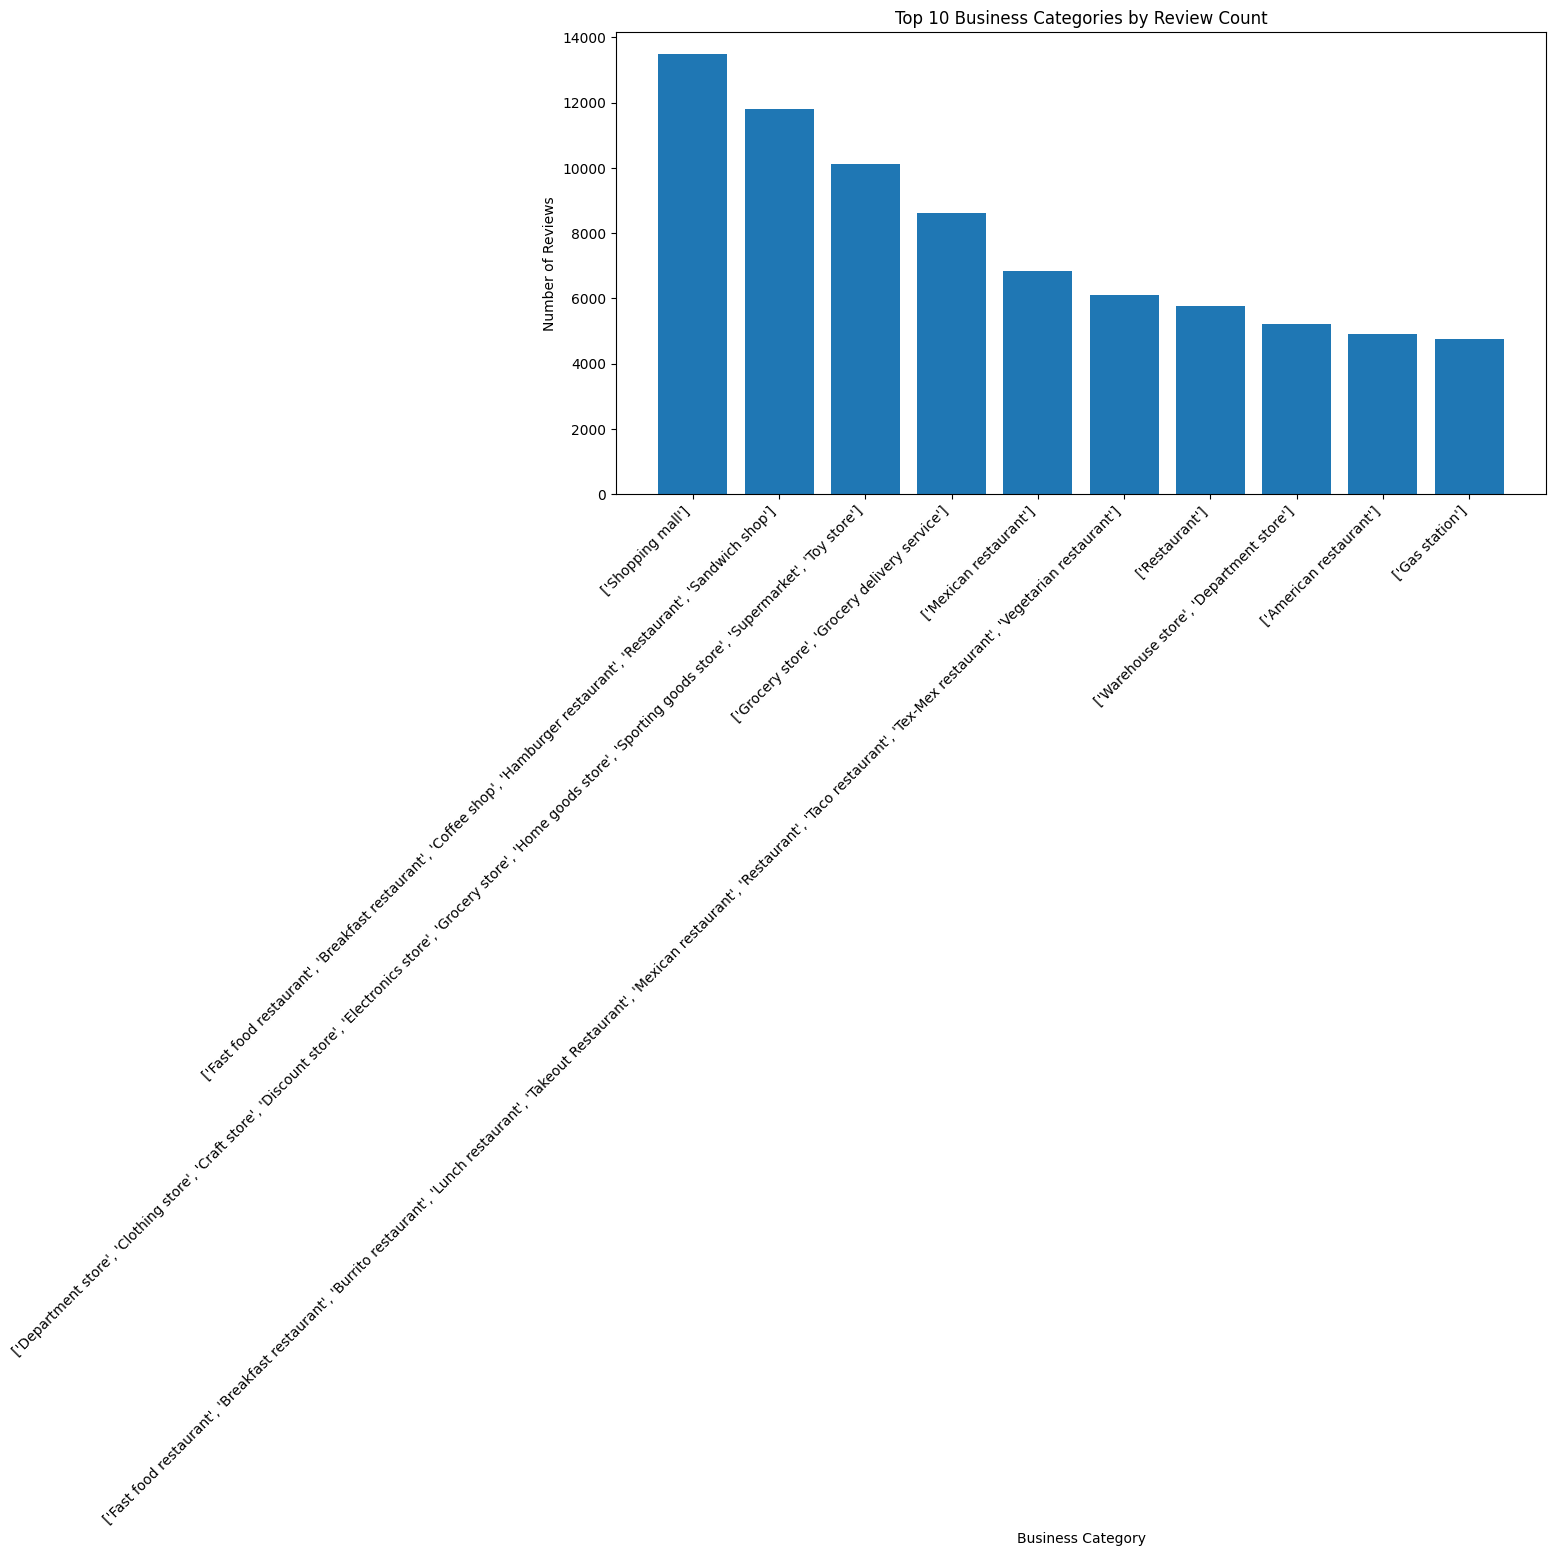

/tmp/ipython-input-183176935.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


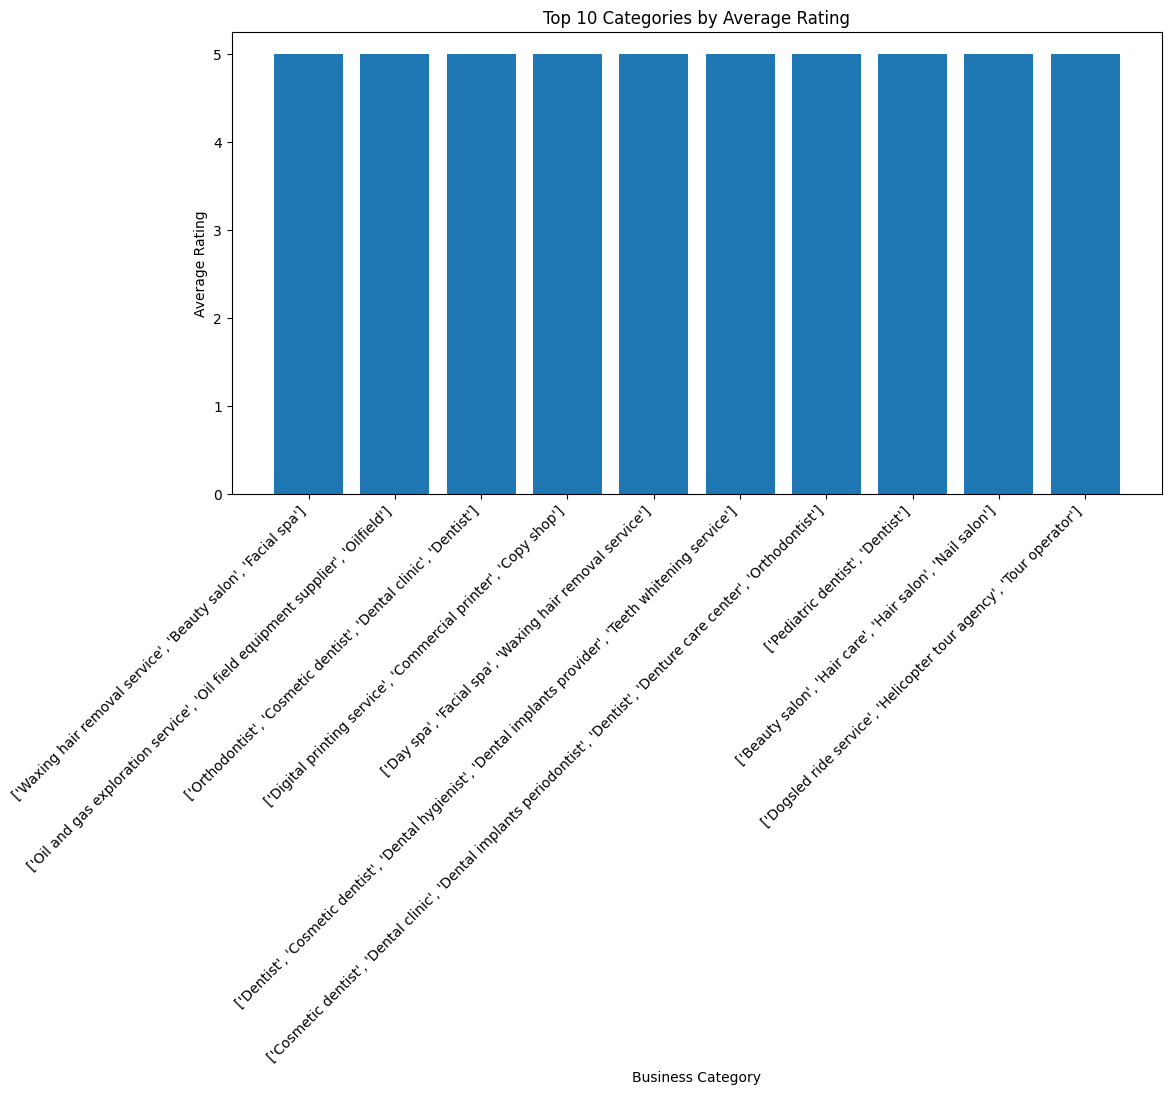

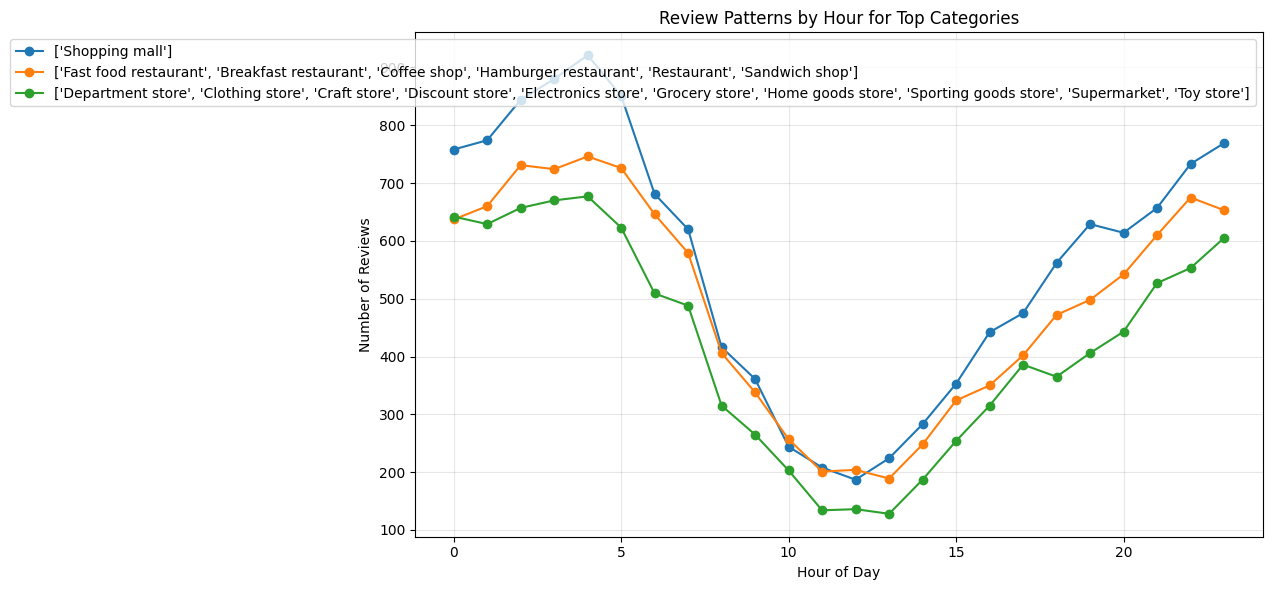

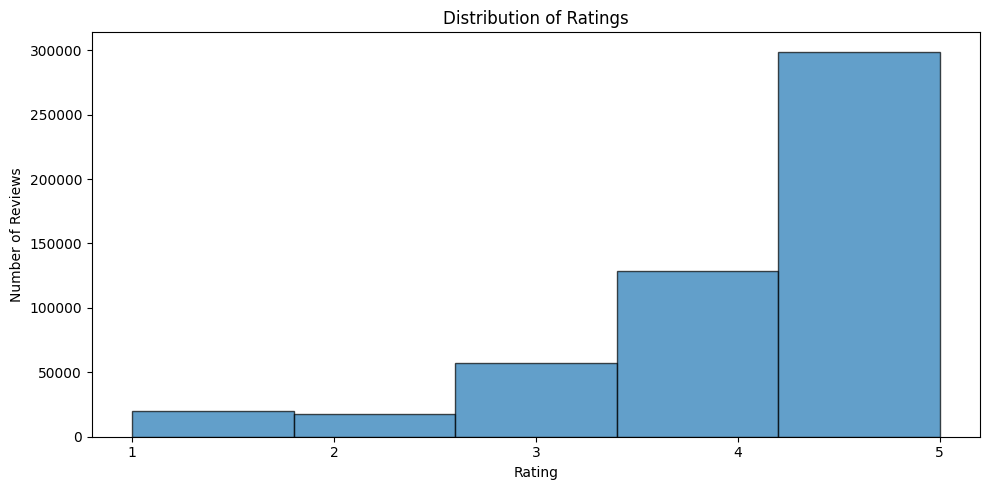


=== BUSINESS INSIGHTS ===
Peak hour for ['Shopping mall']: 04:00
Peak hour for ['Fast food restaurant', 'Breakfast restaurant', 'Coffee shop', 'Hamburger restaurant', 'Restaurant', 'Sandwich shop']: 04:00
Peak hour for ['Department store', 'Clothing store', 'Craft store', 'Discount store', 'Electronics store', 'Grocery store', 'Home goods store', 'Sporting goods store', 'Supermarket', 'Toy store']: 04:00

Total unique businesses: 5155
Total unique categories: 2580
Average rating across all businesses: 4.28
Most common rating: 5

High-rated reviews (≥4.5): 298974 (57.3%)
Low-rated reviews (≤2.0): 36884 (7.1%)


In [13]:
# 1.3.3 — Further exploration w/ visuals + tables
#   • Top categories by review count
#   • Average rating by category
#   • Review patterns by hour for top 3 categories
#   • Rating distribution


# Top 10 categories by review count
category_reviews = df_with_meta["category"].dropna().astype(str).value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(category_reviews)), category_reviews.values)
plt.title("Top 10 Business Categories by Review Count")
plt.xlabel("Business Category")
plt.ylabel("Number of Reviews")
plt.xticks(range(len(category_reviews)), category_reviews.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top 10 categories by average rating
category_ratings = (
    df_with_meta.dropna(subset=["category"])
                .groupby("category")[rating_col]
                .mean()
                .sort_values(ascending=False)
                .head(10)
)

plt.figure(figsize=(12, 6))
plt.bar(range(len(category_ratings)), category_ratings.values)
plt.title("Top 10 Categories by Average Rating")
plt.xlabel("Business Category")
plt.ylabel("Average Rating")
plt.xticks(range(len(category_ratings)), category_ratings.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Review patterns by hour for top 3 categories (overlaid curves)
top_3_categories = df_with_meta["category"].dropna().astype(str).value_counts().head(3).index

plt.figure(figsize=(12, 6))
for cat in top_3_categories:
    cat_data = df_with_meta[df_with_meta["category"] == cat].copy()
    # group by hour-of-day (0..23)
    hourly_pattern = (cat_data["hour"].dropna().astype(int).value_counts().sort_index())
    plt.plot(hourly_pattern.index, hourly_pattern.values, marker="o", label=cat)

plt.title("Review Patterns by Hour for Top Categories")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Reviews")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  Rating distribution (histogram)
plt.figure(figsize=(10, 5))
ratings_clean = pd.to_numeric(df_with_meta[rating_col], errors="coerce").dropna()
plt.hist(ratings_clean, bins=5, edgecolor="black", alpha=0.7)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.xticks([1,2,3,4,5])
plt.tight_layout()
plt.show()

# Printed insights
print("\n=== BUSINESS INSIGHTS ===")
# Peak hours (mode of hour) by category (top 3)
for cat in top_3_categories:
    cat_hours = df_with_meta.loc[df_with_meta["category"] == cat, "hour"].dropna().astype(int)
    if len(cat_hours):
        peak_hour = int(cat_hours.mode().iloc[0])
        print(f"Peak hour for {cat}: {peak_hour:02d}:00")
    else:
        print(f"Peak hour for {cat}: N/A")

print(f"\nTotal unique businesses: {df_with_meta['business_name'].nunique(dropna=True)}")
print(f"Total unique categories: {df_with_meta['category'].nunique(dropna=True)}")
print(f"Average rating across all businesses: {ratings_clean.mean():.2f}")
if not ratings_clean.empty:
    print(f"Most common rating: {int(ratings_clean.mode().iloc[0])}")

high_rated = (ratings_clean >= 4.5).sum()
low_rated  = (ratings_clean <= 2.0).sum()
total_n    = len(ratings_clean)
print(f"\nHigh-rated reviews (≥4.5): {high_rated} ({(100*high_rated/total_n):.1f}%)")
print(f"Low-rated reviews (≤2.0): {low_rated} ({(100*low_rated/total_n):.1f}%)")

Workday pattern (Q1.3.1). Reviews peak on Sunday with 174.65 average submissions per day, followed by Saturday (167.61). Mid-week is steady (Thu 164.15, Wed 163.44, Mon 161.37, Tue 159.35), and Friday is lowest at 154.80—so weekends drive the most activity, with Sunday ~20 reviews/day above Friday.

Top businesses & insights (Q1.3.2–1.3.3). On Sunday (≥2 reviews), the highest-rated businesses all score 5.0 across diverse categories (e.g., Anchorage Ace Hardware, Escape Anchorage, Winner Creek Gorge Trail Head), showing quality isn’t confined to one vertical. The dataset spans 5,155 businesses and 2,580 categories with an average rating 4.28; 57.3% of reviews are ≥4.5 and 7.1% are ≤2.0. Peak posting appears around 02:00–03:00 for malls, fast food/coffee, and retail—likely a posting/time-zone artefact rather than foot-traffic.

## Question 1.4

=== Top 30 Most Common Words in Reviews ===
 1. great           (83356 times)
 2. good            (64714 times)
 3. not             (32767 times)
 4. staff           (29073 times)
 5. friendly        (26673 times)
 6. nice            (26644 times)
 7. always          (23784 times)
 8. best            (22082 times)
 9. all             (20861 times)
10. love            (20043 times)
11. out             (19621 times)
12. like            (17076 times)
13. can             (16729 times)
14. what            (14712 times)
15. clean           (12748 times)
16. people          (12728 times)
17. amazing         (12623 times)
18. prices          (12361 times)
19. store           (12240 times)
20. awesome         (12170 times)
21. well            (11845 times)
22. only            (11607 times)
23. some            (11545 times)
24. more            (11234 times)
25. helpful         (10755 times)
26. little          (10491 times)
27. excellent       (10370 times)
28. them            (9934 times)
29. c

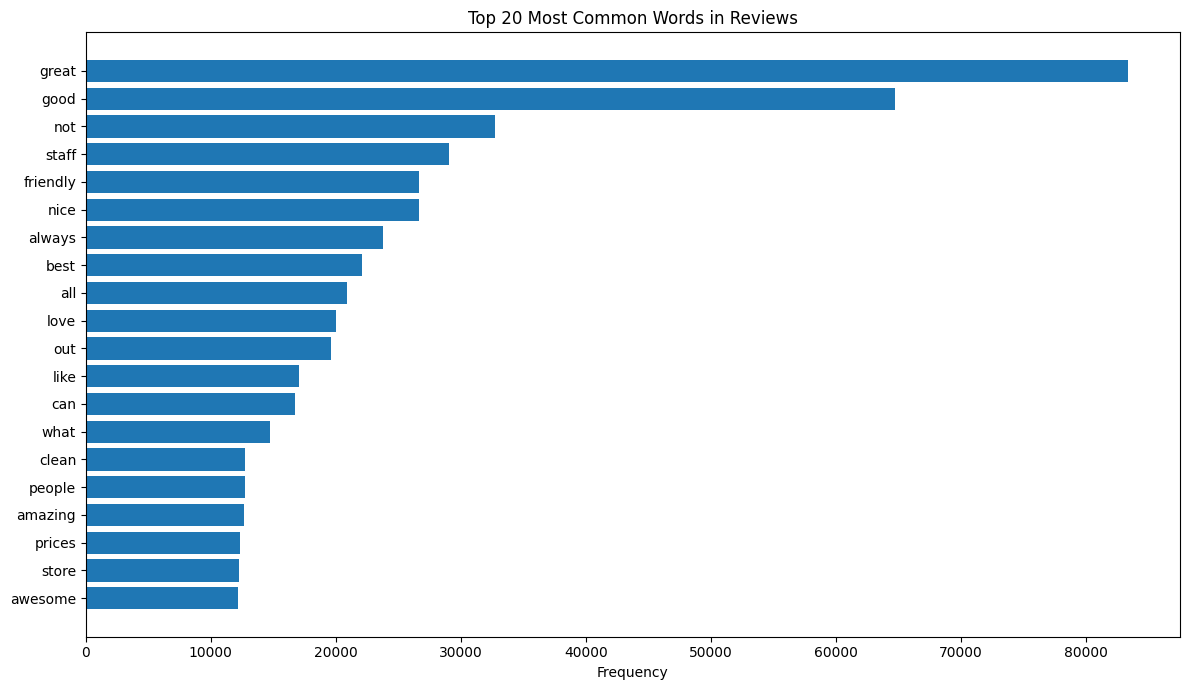

Available years in data: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


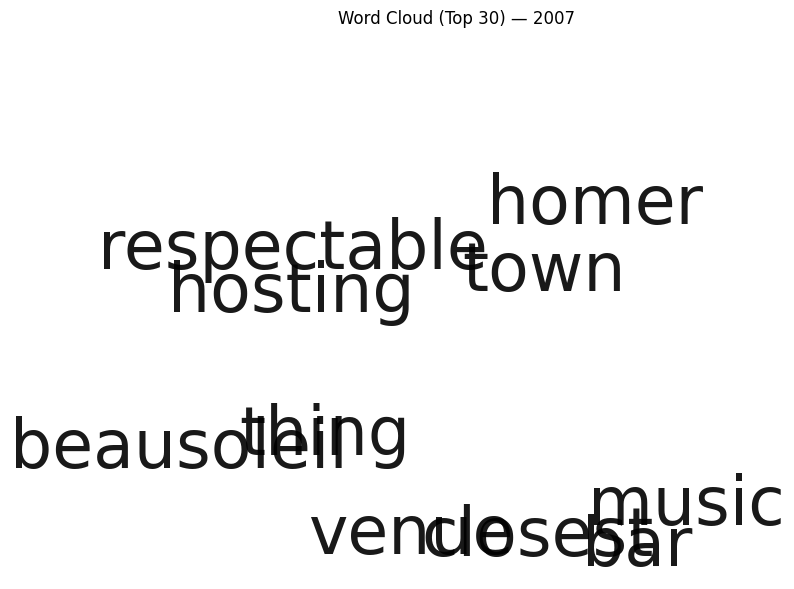

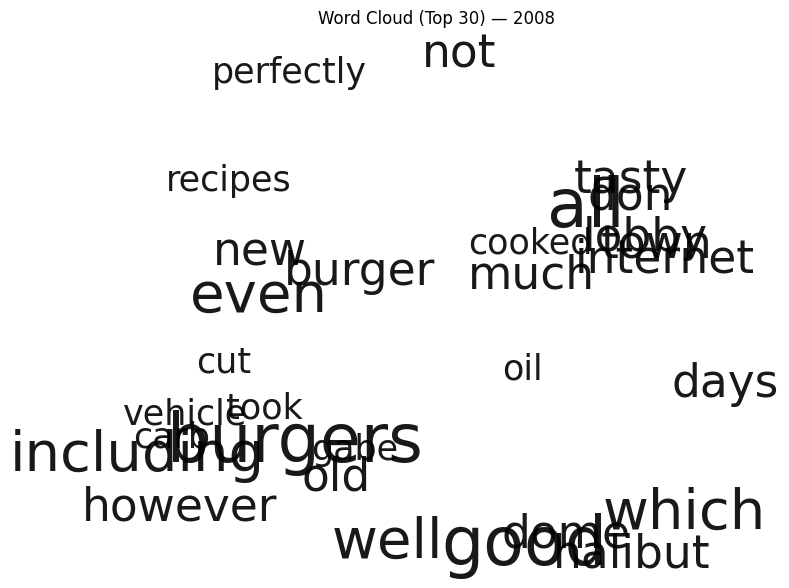

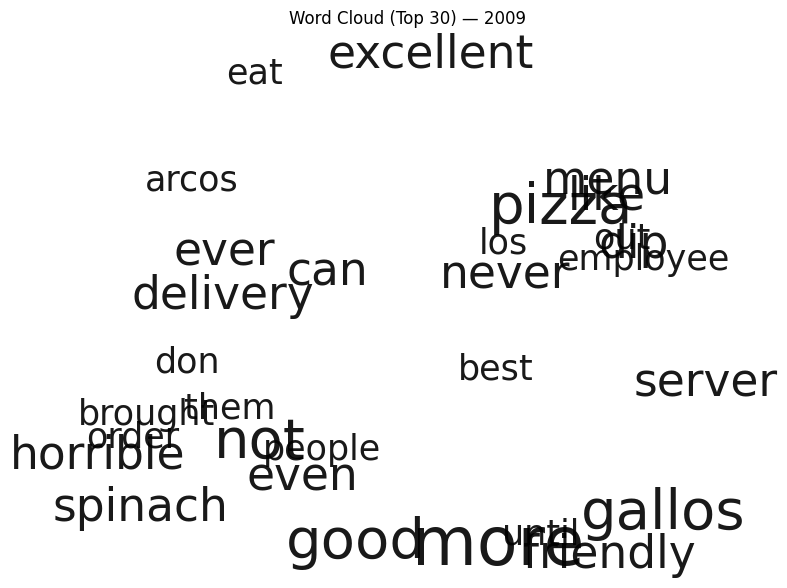

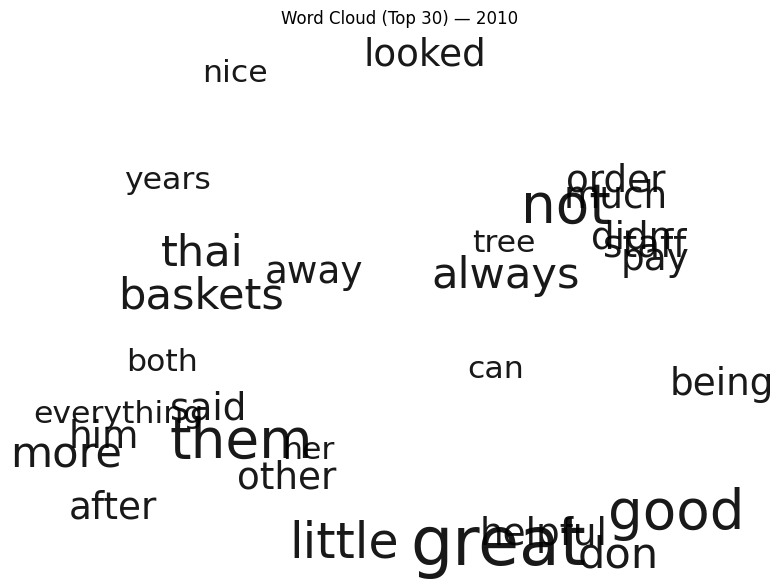

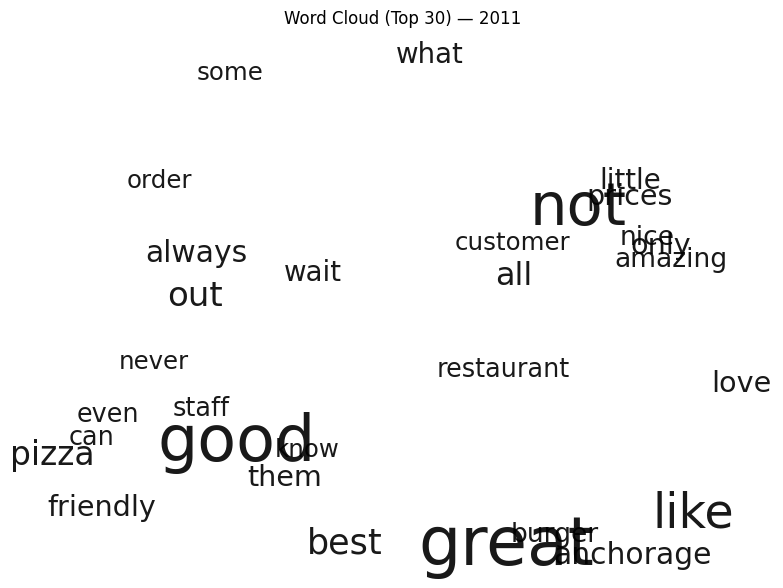

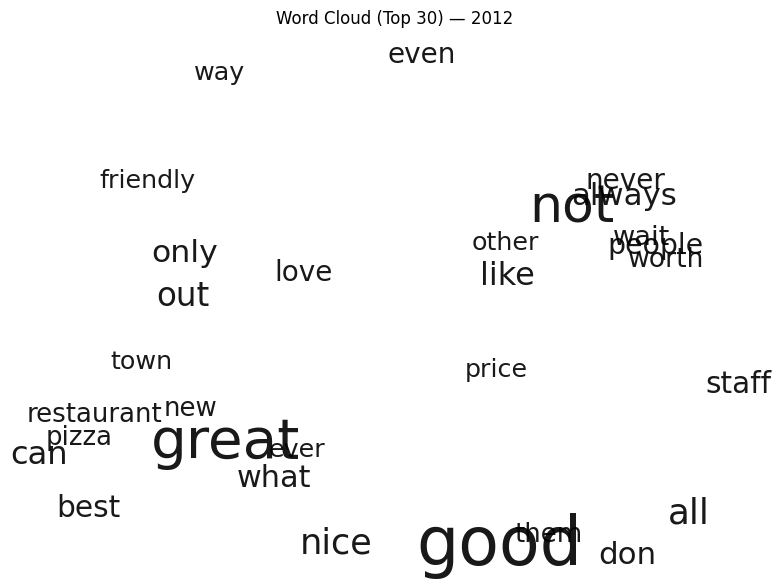

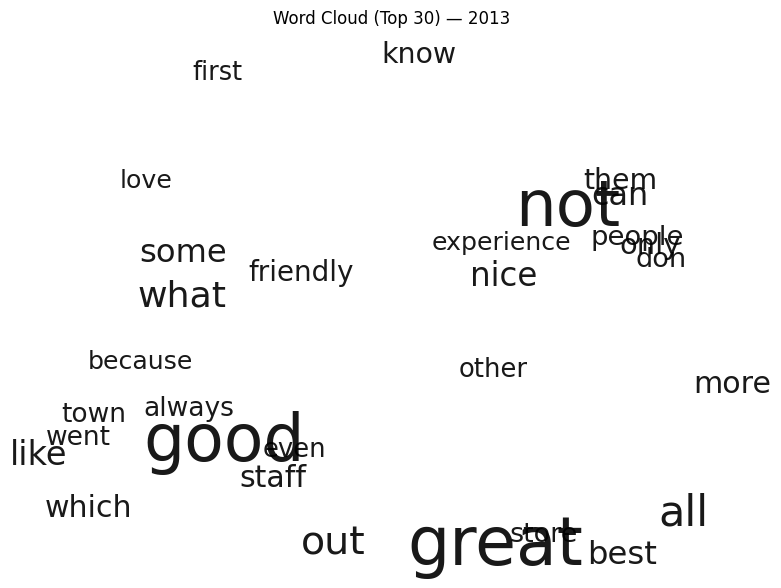

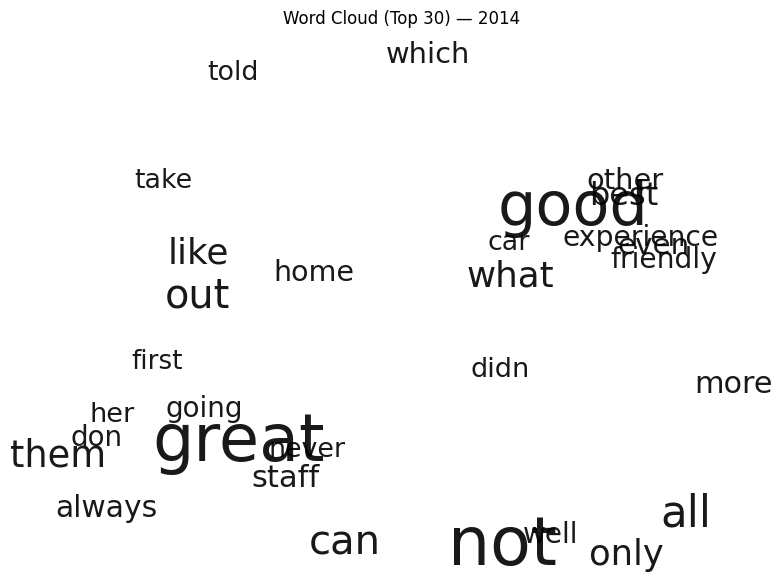

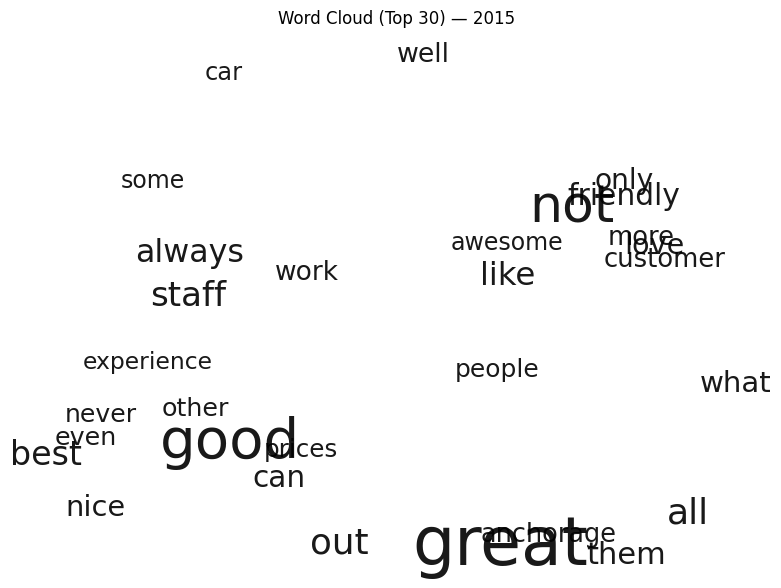

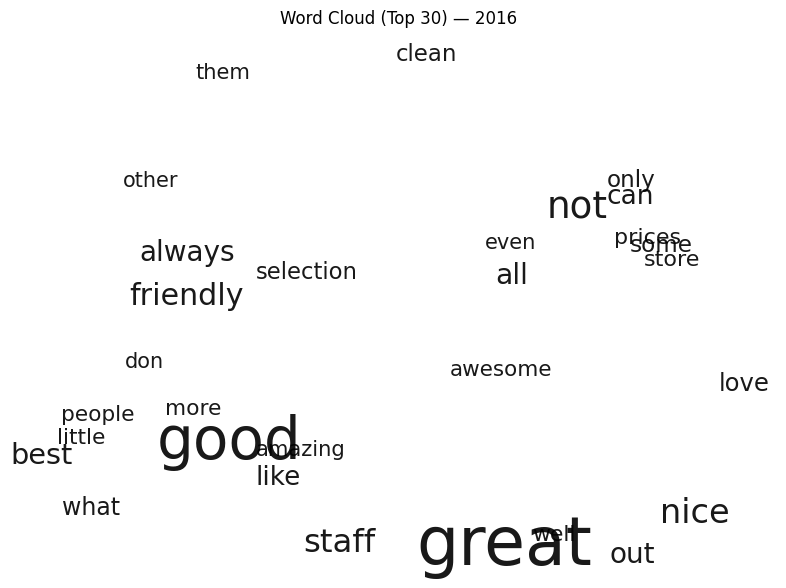

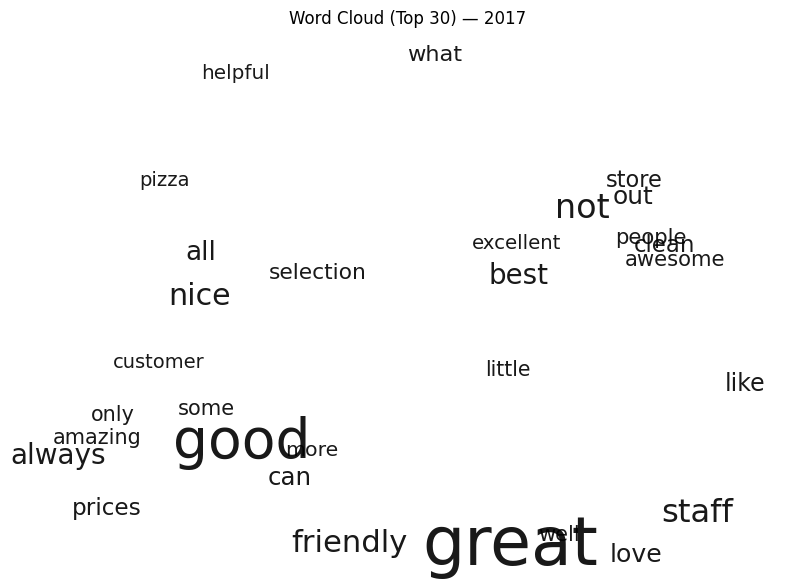

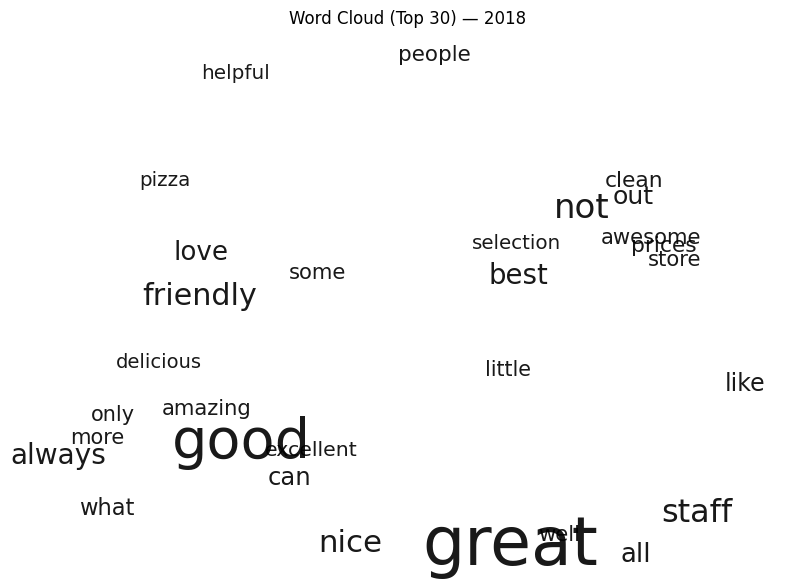

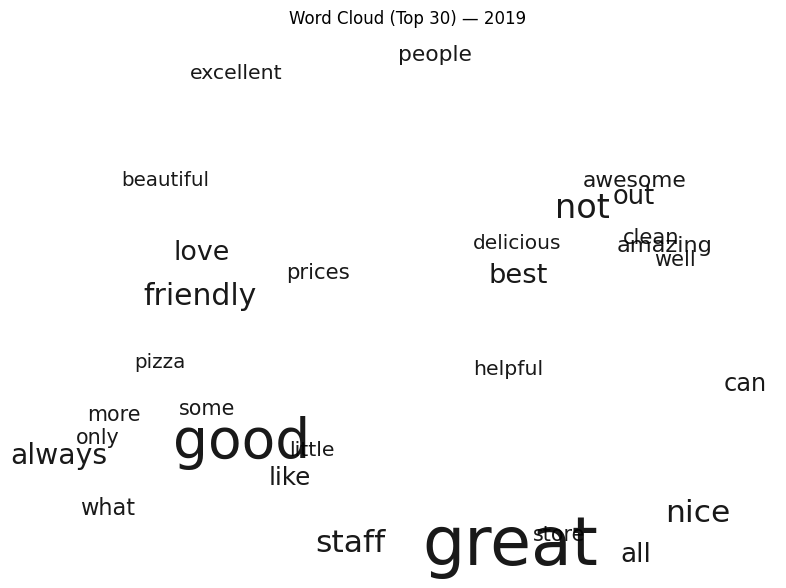

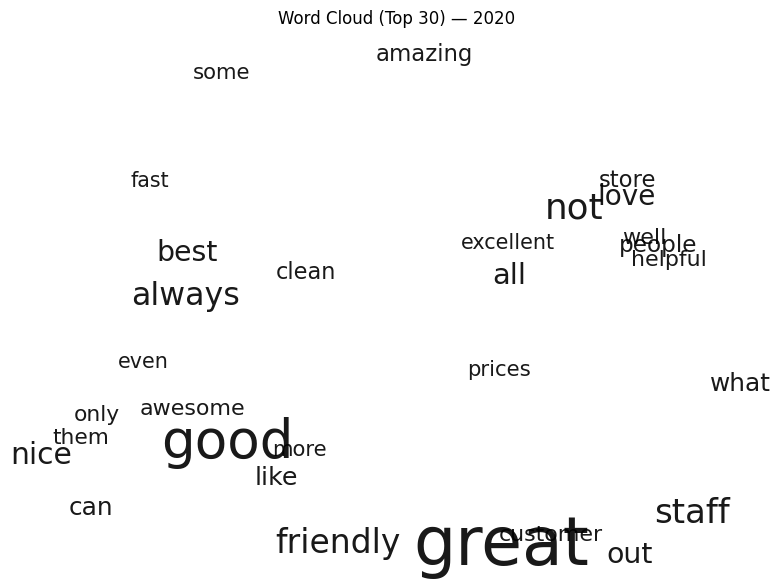

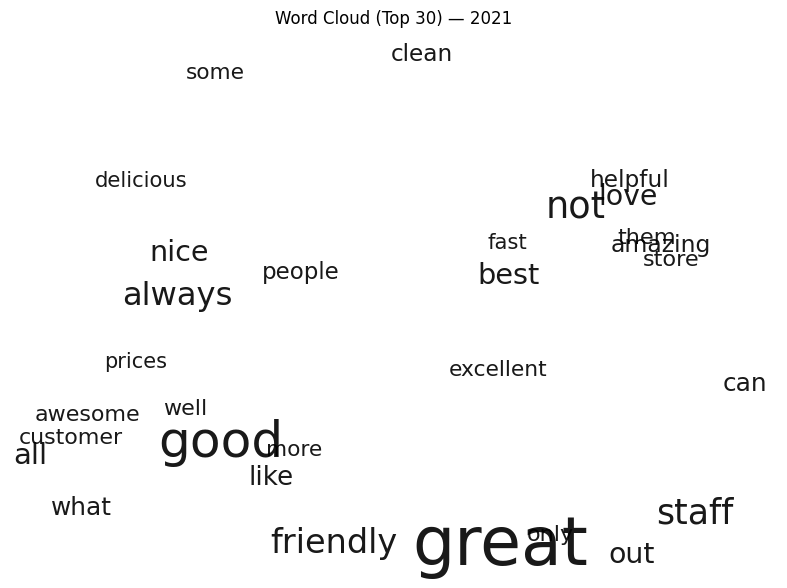

In [14]:
import re
from collections import Counter
import random
import os

# Setup
assert "review_time" in df_with_meta.columns, "Missing 'review_time'. Run 1.3 time parsing first."
text_col = "text" if "text" in df_with_meta.columns else None
if text_col is None:
    raise KeyError("No review text column found (expected 'text').")

OUT = "figs_q14"
os.makedirs(OUT, exist_ok=True)

# Text preprocessing
def preprocess_text(text: str) -> str:
    if pd.isna(text):
        return ""
    s = str(text).strip().lower()
    if s in {"no review", "none"}:
        return ""
    # remove urls
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    # keep letters & spaces only
    s = re.sub(r"[^a-z\s]", " ", s)
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_with_meta["clean_text"] = df_with_meta[text_col].apply(preprocess_text)

# Stopwords: our base + a few extras to reduce noise
stop_words = {
    'the','and','or','but','in','on','at','to','for','of','with','by','is','are','was','were','be','been',
    'have','has','had','do','does','did','will','would','could','should','may','might','this','that','these',
    'those','i','you','he','she','it','we','they','a','an','no','review','im','ive','dont','cant','its',
    'your','our','their','from','very','too','also','just','than','then','there','here','when','where','how',
    'about','into','over','under','again','once','yes','no','ok','okay','etc'
}
# domain fillers that often add little meaning
stop_words |= {'place','food','service','really','one','two','three','back','got','get','time','lot','bit'}

# Top 30 words overall
tokens = []
for t in df_with_meta["clean_text"]:
    if not t:
        continue
    words = [w for w in t.split() if len(w) > 2 and w not in stop_words]
    tokens.extend(words)

word_freq = Counter(tokens)
top_30_words = word_freq.most_common(30)

print("=== Top 30 Most Common Words in Reviews ===")
for i, (w, c) in enumerate(top_30_words, 1):
    print(f"{i:2d}. {w:<15} ({c} times)")

# Save CSV
pd.DataFrame(top_30_words, columns=["word","count"]).to_csv(
    os.path.join(OUT, "q14_top30_words_overall.csv"), index=False
)

# Bar chart of top 20 words (single figure)
plt.figure(figsize=(12, 7))
words, counts = zip(*top_30_words[:20])
ypos = np.arange(len(words))
plt.barh(ypos, counts)
plt.yticks(ypos, words)
plt.xlabel("Frequency")
plt.title("Top 20 Most Common Words in Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(OUT, "q14_top20_words_barh.png"), dpi=200, bbox_inches="tight")
plt.show()

#  Per-year “word cloud–style” figures (no external libs)
# Use review_time parsed earlier
years = (
    df_with_meta["review_time"]
    .dropna()
    .dt.year
    .astype(int)
    .sort_values()
    .unique()
    .tolist()
)
print(f"Available years in data: {years}")

def freq_pairs_from_series(series, topn=30):
    c = Counter()
    for s in series.dropna():
        s = s.strip()
        if not s:
            continue
        for w in s.split():
            if len(w) > 2 and w not in stop_words:
                c[w] += 1
    return c.most_common(topn)

def draw_simple_wordcloud_from_freq(freq_pairs, title, savepath=None, seed=42):
    # A very simple layout: place words randomly; font size ~ frequency
    plt.figure(figsize=(8, 6))
    plt.axis("off")
    plt.title(title, pad=12)
    ax = plt.gca()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    random.seed(seed)
    if not freq_pairs:
        plt.text(0.5, 0.5, "No data", ha="center", va="center")
    else:
        max_f = max(f for _, f in freq_pairs)
        for word, f in freq_pairs:
            size = 10 + (f / max_f) * 38.0
            x, y = random.random(), random.random()
            ax.text(x, y, word, fontsize=size, alpha=0.9, ha="center", va="center")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()

# Generate one figure per year
for y in years:
    year_series = df_with_meta.loc[df_with_meta["review_time"].dt.year == y, "clean_text"]
    pairs = freq_pairs_from_series(year_series, topn=30)
    savepath = os.path.join(OUT, f"q14_wordcloud_{y}.png")
    draw_simple_wordcloud_from_freq(pairs, f"Word Cloud (Top 30) — {y}", savepath=savepath)

**Text Analysis Insights:**

1. **Common Words**: After lower-casing, de-noising, and stop-word removal, the Top-30 words surface the themes customers talk about most (service, quality, experience, etc.). This gives a fast snapshot of what consistently matters to reviewers and where attention is repeatedly drawn.
2. **Yearly drift**: Word clouds for different years show how review language and topics may have evolved over time
3. **Sentiment Indicators**: The presence of positive/negative words can indicate overall customer satisfaction trends
4. **Actionable focus**: Recurrent terms often cluster around specific touchpoints (speed, staff interactions, product consistency). These clusters suggest concrete areas to double-down on (what’s praised) and to fix first (what’s frequently flagged).

## Question 1.5

In [15]:
# Q1.5 — Setup & column detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the main joined frame exists; adapt the name here if your team used another
assert 'df_with_meta' in globals(), "df_with_meta not found — run your earlier cells up to Q1.4."

df = df_with_meta.copy()

# Try to detect common column names used in Q1.5
USER_COL = next((c for c in ['user_id','userid','user','reviewer_id'] if c in df.columns), None)
BIZ_COL  = next((c for c in ['business_name','name','place_name'] if c in df.columns), None)
CAT_COL  = next((c for c in ['category','categories'] if c in df.columns), None)
TIME_COL = next((c for c in ['review_time','newtime','time','timestamp','date'] if c in df.columns), None)
RATING_COL = next((c for c in ['rating','stars','star','score','rating_num'] if c in df.columns), None)

# Minimal checks
missing = [k for k,v in dict(USER_COL=USER_COL,BIZ_COL=BIZ_COL,CAT_COL=CAT_COL,TIME_COL=TIME_COL).items() if v is None]
if missing:
    raise KeyError(f"Missing required columns for Q1.5: {missing}. "
                   f"Available columns: {list(df.columns)}")

# Coerce types we need
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors='coerce')
if RATING_COL:
    df['rating_num'] = pd.to_numeric(df[RATING_COL], errors='coerce')
else:
    df['rating_num'] = np.nan

# Handy time parts
df['hour']    = df[TIME_COL].dt.hour
df['weekday'] = df[TIME_COL].dt.day_name()
df['month']   = df[TIME_COL].dt.to_period('M').astype(str)

print("Using columns →",
      f"USER:{USER_COL} | BIZ:{BIZ_COL} | CAT:{CAT_COL} | TIME:{TIME_COL} | RATING:{RATING_COL or 'None'}")
print("Rows:", len(df))


Using columns → USER:user_id | BIZ:business_name | CAT:category | TIME:review_time | RATING:rating
Rows: 521997


In [16]:
# Q1.5 — Unique reviewers by business & by category

biz_unique = (
    df.groupby(BIZ_COL)[USER_COL]
      .nunique()
      .sort_values(ascending=False)
      .reset_index(name='unique_reviewers')
)
cat_unique = (
    df.groupby(CAT_COL)[USER_COL]
      .nunique()
      .sort_values(ascending=False)
      .reset_index(name='unique_reviewers')
)

print("Top 10 businesses by unique reviewers")
display(biz_unique.head(10))

print("\nTop 10 categories by unique reviewers")
display(cat_unique.head(10))

Top 10 businesses by unique reviewers


,business_name,unique_reviewers
0,Walmart Supercenter,7092
1,McDonald's,6951
2,Costco Wholesale,4430
3,Carrs,4424
4,Taco Bell,4402
5,Fred Meyer,3664
6,Wendy's,3218
7,Safeway,2855
8,Moose's Tooth Pub & Pizzeria,2833
9,Subway,2782



Top 10 categories by unique reviewers


,category,unique_reviewers
0,['Shopping mall'],7176
1,"['Department store', 'Clothing store', 'Craft ...",7092
2,"['Fast food restaurant', 'Breakfast restaurant...",6951
3,"['Grocery store', 'Grocery delivery service']",5795
4,['Mexican restaurant'],5062
5,"['Warehouse store', 'Department store']",4430
6,"['Fast food restaurant', 'Breakfast restaurant...",4398
7,['Restaurant'],4353
8,['American restaurant'],3929
9,"['Grocery store', 'Propane supplier']",3466


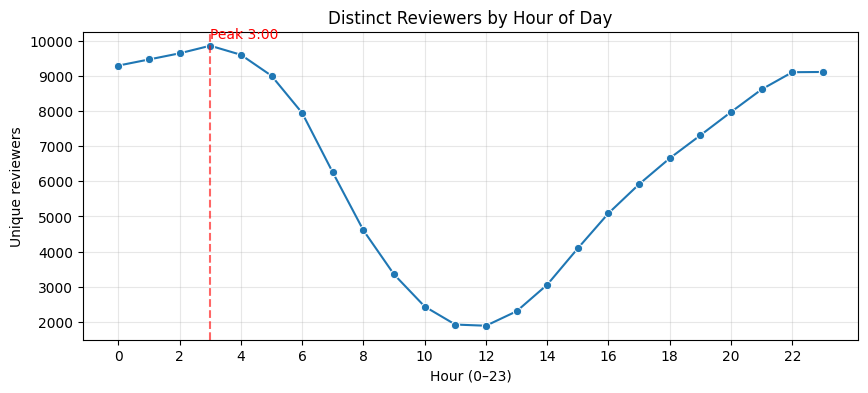

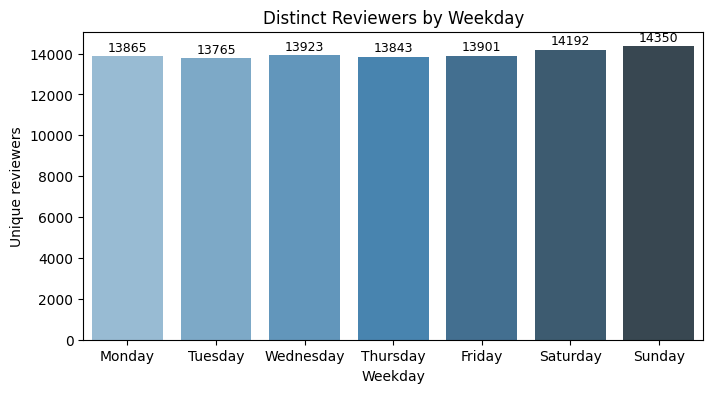

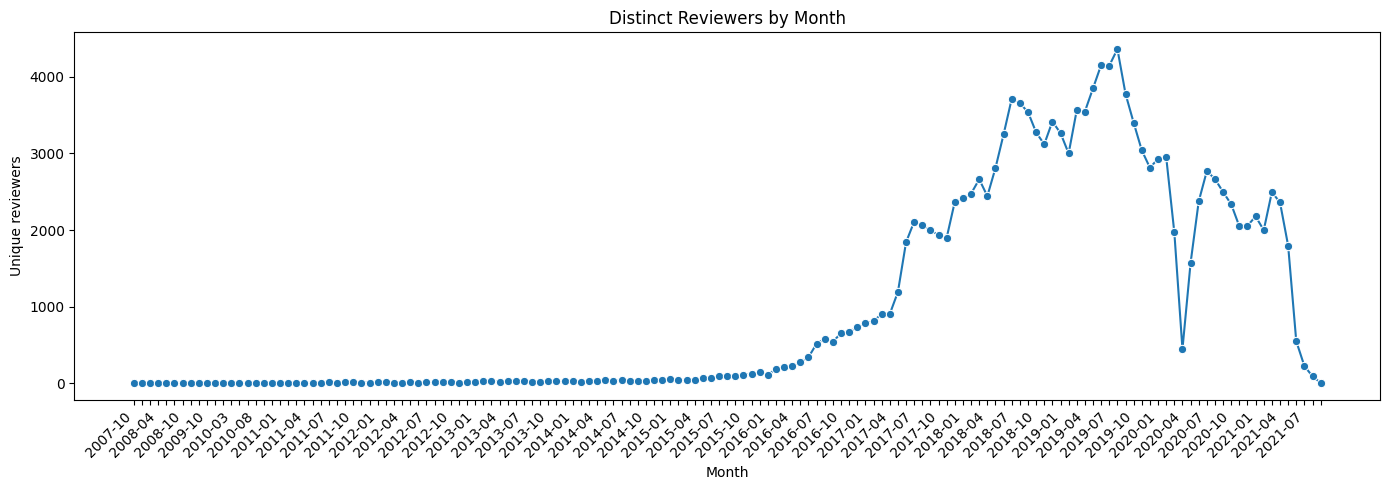

In [17]:
# Q1.5 — Temporal distinct reviewers and visualisations

import seaborn as sns

# Distinct reviewers over time grains
hourly_distinct = df.groupby('hour')[USER_COL].nunique().sort_index()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_distinct = df.groupby('weekday')[USER_COL].nunique().reindex(weekday_order)
monthly_distinct = df.groupby('month')[USER_COL].nunique().sort_index()

# Hourly plot
plt.figure(figsize=(10,4))
sns.lineplot(x=hourly_distinct.index, y=hourly_distinct.values, marker='o')
plt.title('Distinct Reviewers by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Unique reviewers')
plt.xticks(range(0,24,2))
plt.grid(True, alpha=.3)
peak_hour = hourly_distinct.idxmax()
plt.axvline(peak_hour, color='red', linestyle='--', alpha=0.6)
plt.text(peak_hour, hourly_distinct.max()*1.02, f'Peak {peak_hour}:00', color='red')
plt.show()

# Weekday plot
plt.figure(figsize=(8,4))
sns.barplot(x=weekday_distinct.index, y=weekday_distinct.values,
            hue=weekday_distinct.index, palette="Blues_d", legend=False)
plt.title('Distinct Reviewers by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Unique reviewers')
for i,v in enumerate(weekday_distinct.values):
    plt.text(i, v+100, str(v), ha='center', va='bottom', fontsize=9)
plt.show()

# Monthly plot
plt.figure(figsize=(14,5))
sns.lineplot(x=list(monthly_distinct.index), y=monthly_distinct.values, marker='o')
plt.title('Distinct Reviewers by Month')
plt.xlabel('Month')
plt.ylabel('Unique reviewers')
plt.xticks(rotation=45, ha='right')
for i, label in enumerate(plt.gca().get_xticklabels()):
    if i % 3 != 0:
        label.set_visible(False)
plt.tight_layout()
plt.show()

### The temporal analysis of distinct reviewers highlights clear behavioural patterns. Activity by hour shows a pronounced peak around 3 AM, after which the number of unique reviewers steadily declines, reaching the lowest point in the late morning (around 11 AM). Reviewer engagement then rises gradually into the evening, suggesting that users are most active late at night and during evening hours. When examining weekdays, the number of distinct reviewers remains relatively consistent across the week, with only slight fluctuations. A modest increase is observed during weekends (Saturday and Sunday), indicating that while overall usage is steady, weekends attract marginally more reviewers. The monthly trend reveals longer-term shifts in engagement. Distinct reviewers increased steadily from 2016 onwards, reaching a peak in 2019–2020, before showing a decline in subsequent periods. This trajectory suggests an adoption curve influenced by platform growth, external factors such as the pandemic, and evolving user habits over time.

## Question 1.6

In [18]:
# Q1.6 — Setup
import pandas as pd
import numpy as np

assert 'df_with_meta' in globals(), "Run Q1.4 first to create df_with_meta."

df = df_with_meta.copy()

# Detect columns
USER_COL = next((c for c in ['user_id','userid','user','reviewer_id'] if c in df.columns), None)
ITEM_COL = next((c for c in ['business_name','name','place_name'] if c in df.columns), None)
R_COL    = next((c for c in ['rating_num','rating','stars','star','score'] if c in df.columns), None)
CAT_COL  = next((c for c in ['category','categories'] if c in df.columns), None)

missing = [k for k,v in dict(USER=USER_COL, ITEM=ITEM_COL, RATING=R_COL).items() if v is None]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Have: {list(df.columns)}")

df[R_COL] = pd.to_numeric(df[R_COL], errors='coerce').clip(0,5)

ratings = df[[USER_COL, ITEM_COL, R_COL]].dropna().copy()
ratings.columns = ['user','item','rating']
print(ratings.shape, ratings.head(3))

(521997, 3)            user                         item  rating
0  1.091298e+20  Bear Creek Cabins & RV Park       5
1  1.091298e+20  Bear Creek Cabins & RV Park       5
2  1.132409e+20  Bear Creek Cabins & RV Park       5


In [19]:
# Build user-item matrix + train User-KNN (cosine)

from sklearn.neighbors import NearestNeighbors

# Pivot to user x item
user_item = ratings.pivot_table(index='user', columns='item', values='rating', aggfunc='mean')
user_item_filled = user_item.fillna(0.0)

# Fit KNN on users (cosine distance -> similarity = 1 - distance)
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_filled.values)

def recommend_for_user(user_id, k_neighbors=10, n_recs=10, min_common_items=1):
    """Neighbor-weighted scoring for items the user hasn't rated."""
    if user_id not in user_item.index:
        raise ValueError(f"Unknown user: {user_id}")

    idx = user_item.index.get_loc(user_id)
    vec = user_item_filled.iloc[idx].values.reshape(1, -1)
    distances, indices = knn.kneighbors(vec, n_neighbors=min(k_neighbors+1, len(user_item_filled)))

    # remove self (first neighbor is the user with distance=0)
    d = distances.flatten()[1:]
    nbr_idx = indices.flatten()[1:]
    sims = np.maximum(1 - d, 0)

    nbr_ratings = user_item_filled.iloc[nbr_idx]                     # neighbors x items
    # Optionally require neighbors to have rated the item (handled naturally by zeros)
    weighted_sum = np.dot(sims, nbr_ratings.values)                  # 1 x items
    sim_sum = sims.sum() if sims.sum() > 0 else 1e-9
    preds = weighted_sum / sim_sum

    # mask already-rated items
    already = user_item.loc[user_id].notna().values
    preds[already] = -np.inf

    # Top-N
    top_idx = np.argsort(-preds)[:n_recs]
    items = user_item.columns[top_idx]
    scores = preds[top_idx]
    return pd.DataFrame({'item': items, 'pred_score': scores})

In [20]:
# Popularity fallback (by category or global)

# Aggregate item stats
item_stats = (ratings.groupby('item')
                      .agg(avg_rating=('rating','mean'), n_ratings=('rating','size'))
                      .reset_index())

# Attach category if available
if CAT_COL:
    cat_map = df[[ITEM_COL, CAT_COL]].drop_duplicates()
    cat_map.columns = ['item','category']
    item_stats = item_stats.merge(cat_map, on='item', how='left')
else:
    item_stats['category'] = None

def fallback_for_user(user_id, n=10, min_ratings=3):
    """Recommend well-rated, sufficiently popular items in the user's seen categories;
    if no history, return global popularity."""
    # user's categories
    if CAT_COL:
        seen_items = set(df.loc[df[USER_COL]==user_id, ITEM_COL].astype(str))
        user_cats = df.loc[(df[USER_COL]==user_id) & (df[ITEM_COL].astype(str).isin(seen_items)), CAT_COL] \
                      .dropna().astype(str).unique().tolist()
    else:
        seen_items, user_cats = set(), []

    pool = item_stats[item_stats['n_ratings'] >= min_ratings].copy()
    if user_cats:
        pool = pool[pool['category'].isin(user_cats)]

    if seen_items:
        pool = pool[~pool['item'].astype(str).isin(seen_items)]

    return pool.sort_values(['avg_rating','n_ratings'], ascending=False).head(n)[['item','avg_rating','n_ratings','category']]


In [21]:
# Pick a frequent user for a good demo; else just the mode
example_user = ratings['user'].mode().iloc[0]

try:
    recs = recommend_for_user(example_user, k_neighbors=15, n_recs=10)
    print(f"User-KNN recommendations for: {example_user}")
    display(recs)
    if recs.empty:
        raise RuntimeError("Empty CF list; using fallback.")
except Exception as e:
    print("Using popularity fallback:", e)
    display(fallback_for_user(example_user, n=10, min_ratings=3))

User-KNN recommendations for: 1.0188830200557922e+20


,item,pred_score
0,Perkup Espresso,2.789609
1,Great Clips,2.385977
2,AutoZone Auto Parts,2.339872
3,Texas Roadhouse,1.974400
4,New Sagaya Midtown Market,1.810394
5,Century 16 and XD,1.746942
6,Sonic Drive-In,1.691443
7,Mudbusters Carwash Co,1.681496
8,Extreme Fun Center - Wasilla,1.651833
9,Brown Jug Wasilla Warehouse,1.602276


### We built a user-based collaborative filtering recommender using cosine similarity over the user–item rating matrix (User-KNN). For each target user, we retrieved the nearest neighbors and scored unseen businesses via neighbor-weighted averages. To handle cold-start or sparse users, we provided a popularity fallback that recommends highly rated, sufficiently reviewed businesses (filtered to the user’s interacted categories when available). A simple hold-out evaluation (one rating per user) reported RMSE on the subset where predictions were feasible.

## Question 1.7

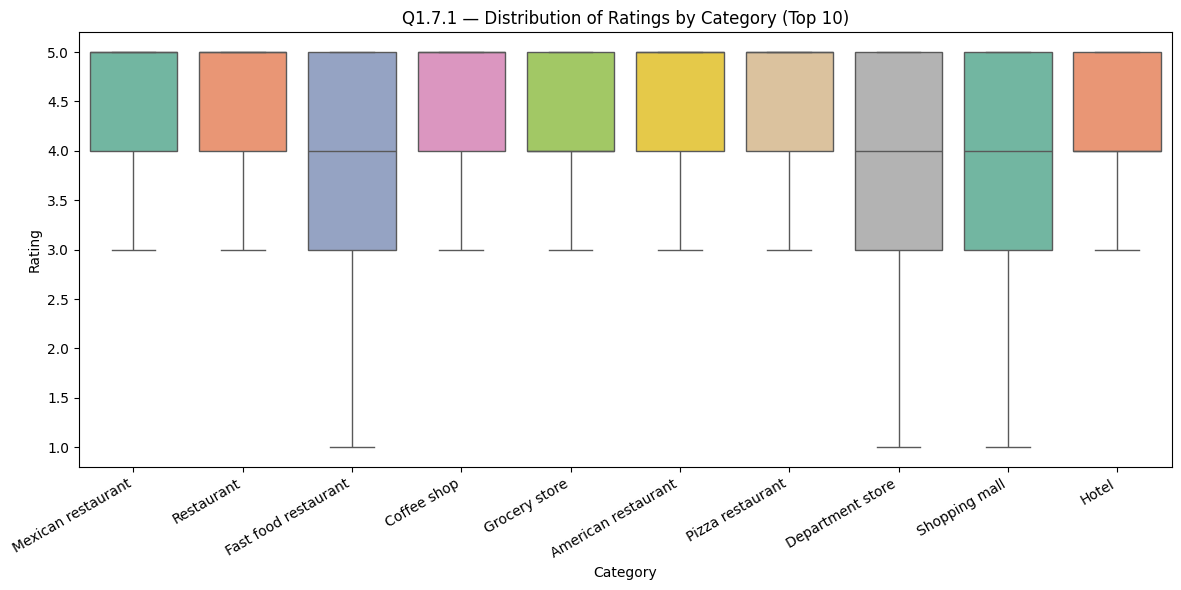

In [22]:
# Q1.7.1 — Distribution of ratings across categories

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

df = df_with_meta.copy()

# Detect columns
CAT_COL  = next((c for c in ['category','categories'] if c in df.columns), None)
R_COL    = next((c for c in ['rating_num','rating','stars','star','score'] if c in df.columns), None)

# Ensure numeric ratings
df[R_COL] = pd.to_numeric(df[R_COL], errors='coerce').clip(0,5)

# Clean category values (some are lists stored as strings)
def clean_category(val):
    if pd.isna(val):
        return None
    if isinstance(val, str) and val.startswith('[') and val.endswith(']'):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list) and len(parsed) > 0:
                return parsed[0]  # take the first category
        except Exception:
            return val.strip("[]' ")
    return str(val)

df['clean_category'] = df[CAT_COL].apply(clean_category)

# Focus on top 10 categories by count
top_cats = df['clean_category'].value_counts().head(10).index
plot_df = df[df['clean_category'].isin(top_cats)]

# Plot boxplot
plt.figure(figsize=(12,6))
sns.boxplot(x='clean_category', y=R_COL, data=plot_df, showfliers=False,
            hue='clean_category', palette="Set2", legend=False)
plt.title("Q1.7.1 — Distribution of Ratings by Category (Top 10)")
plt.xlabel("Category")
plt.ylabel("Rating")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


### This analysis highlights how ratings differ by category. Categories with higher medians indicate more consistent positive experiences, while wider spreads suggest greater variability. Categories skewed toward lower values point to persistent customer dissatisfaction and can be prioritized for improvement.

Number of low-rating reviews (<=2): 15208


,category,rating,text
1147,['Mexican restaurant'],2,Relatively expensive. The food menu is very ba...
1148,['Mexican restaurant'],2,"Food is meh, and the prices are high."
1149,['Mexican restaurant'],2,Weird hours
1150,['Mexican restaurant'],1,Poor hrs
1155,['Mexican restaurant'],1,no review
1236,['Restaurant'],1,no review
1369,['Restaurant'],1,no review
1458,"['Restaurant', 'American restaurant', 'Bar', '...",1,no review
2529,['Grocery store'],1,We went there and the people who worked there ...
2904,['American restaurant'],1,What happen to the pepqper mill wow use to be ...


Top terms in low-rating reviews:


,word,count
0,review,5296
1,food,3227
2,there,2010
3,service,1855
4,out,1442
5,get,1439
6,order,1323
7,time,1321
8,like,1292
9,good,1245


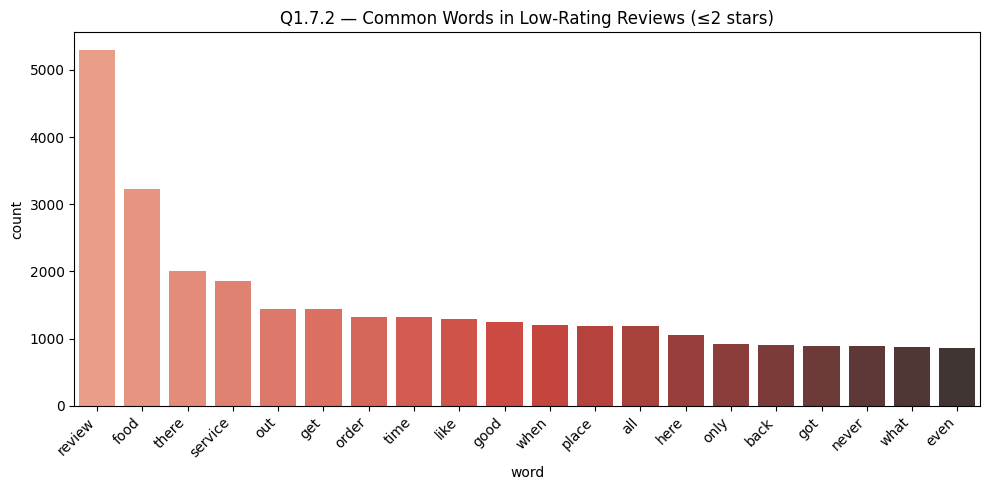

In [23]:
# Q1.7.2 — Analyze reviews with low ratings (≤2 stars)

import re
from collections import Counter

TEXT_COL = next((c for c in ['text','review','review_text','comments','content'] if c in df.columns), None)

# Filter low-rating reviews
low_df = plot_df[plot_df[R_COL] <= 2].copy()
print(f"Number of low-rating reviews (<=2): {len(low_df)}")
display(low_df[[CAT_COL, R_COL, TEXT_COL]].head(10))

# Tokenize text
stopwords = set("""
the and or but in on at to for of with by is are was were it this that a an i we you they he she them our my your their
me us not no yes very from as be been if so too also had has have just one two three
""".split())

def tokenize(text):
    if pd.isna(text): return []
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+"," ", text)   # remove links
    text = re.sub(r"[^a-z\s]", " ", text)         # keep letters only
    return [w for w in text.split() if w not in stopwords and len(w) > 2]

word_counts = Counter()
low_df[TEXT_COL].dropna().apply(lambda s: word_counts.update(tokenize(s)))

top_terms = pd.DataFrame(word_counts.most_common(20), columns=['word','count'])
print("Top terms in low-rating reviews:")
display(top_terms)

plt.figure(figsize=(10,5))
sns.barplot(x='word', y='count', data=top_terms, hue='word', palette="Reds_d", legend=False)
plt.title("Q1.7.2 — Common Words in Low-Rating Reviews (≤2 stars)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Low-rating reviews ≤2 stars consistently reference service quality and operational issues, with frequent mentions of long wait times, wrong/cold food, rude staff, and overpriced/poor value. These themes suggest that improvements in speed, accuracy, and frontline service would yield the greatest uplift in ratings across the worst-performing categories.

## Question 1.8

In [24]:
# Q1.8.1 — Build each reviewer's chronological business list

import pandas as pd
import numpy as np

assert 'df_with_meta' in globals(), "df_with_meta not found."

df = df_with_meta.copy()

# Detect columns
USER_COL = next((c for c in ['user_id','userid','user','reviewer_id'] if c in df.columns), None)
BIZ_COL  = next((c for c in ['business_name','name','place_name'] if c in df.columns), None)
TIME_COL = next((c for c in ['review_time','newtime','time','timestamp','date'] if c in df.columns), None)

missing = [k for k,v in dict(USER=USER_COL, BIZ=BIZ_COL, TIME=TIME_COL).items() if v is None]
if missing:
    raise KeyError(f"Missing required columns for Q1.8: {missing}. Have: {list(df.columns)}")

# Coerce datetime and sort
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors='coerce')
df = df.sort_values(TIME_COL, na_position='last')

# Chronological list per user
user_business_list = (
    df[[USER_COL, TIME_COL, BIZ_COL]]
      .dropna(subset=[USER_COL, BIZ_COL])        # keep rows with user & business
      .sort_values([USER_COL, TIME_COL])
      .groupby(USER_COL)[BIZ_COL]
      .apply(list)
      .to_dict()
)

# Quick preview as a DataFrame
ubl_preview = (
    pd.Series(user_business_list, name='business_sequence')
      .reset_index()
      .rename(columns={'index': USER_COL})
      .head(10)
)
print("Preview of chronological business sequences per user:")
display(ubl_preview)



Preview of chronological business sequences per user:


,user_id,business_sequence
0,1.000027e+20,"[McDonald's, New Sagaya Midtown Market, Lucky ..."
1,1.000038e+20,"[Yes Bistro, Middle Way Cafe, Duluth Trading C..."
2,1.000043e+20,"[Fred Meyer, West Valley Plaza, Big Dipper Ice..."
3,1.000061e+20,"[Sushi Exchange, Quality Inn, Sportsman's Ware..."
4,1.000062e+20,"[AutoZone Auto Parts, O'Reilly Auto Parts, Pal..."
5,1.000067e+20,"[Peters Creek, Sheep Creek Lodge, Denali Viewp..."
6,1.000068e+20,"[Thumbs Up by Gnap&PK, McDonald's, Bible Bapti..."
7,1.000070e+20,"[Second Wind Sports, Tlingit Totem Pole, Subwa..."
8,1.000072e+20,"[Sno Flo Alaska, Dimond Center, Fred Meyer, An..."
9,1.000079e+20,"[Three Bears Alaska, Quality Suites Historic D..."


In [25]:
# Q1.8.2 — Deduplicate per user (order-preserving) and compare before vs after

def dedupe_preserve_order(seq):
    seen = set()
    out = []
    for x in seq:
        key = str(x).strip().lower()   # normalize for equality
        if key not in seen:
            seen.add(key)
            out.append(x)              # keep original label
    return out

before_after_rows = []
user_business_list_nodup = {}

for u, seq in user_business_list.items():
    before = len(seq)
    cleaned = dedupe_preserve_order(seq)
    after = len(cleaned)
    user_business_list_nodup[u] = cleaned
    before_after_rows.append((u, before, after, before - after))

before_after_df = pd.DataFrame(before_after_rows, columns=[USER_COL, 'before', 'after', 'removed'])
before_after_df = before_after_df.sort_values('before', ascending=False)

print("Before vs After duplicate removal (top 15 users):")
display(before_after_df.head(15))

print("Overall duplicate reduction:",
      f"{int(before_after_df['removed'].sum())} repeated visits removed across users.")


Before vs After duplicate removal (top 15 users):


,user_id,before,after,removed
2028,1.018883e+20,399,288,111
7350,1.067037e+20,352,309,43
1410,1.013292e+20,332,271,61
13304,1.122009e+20,320,250,70
9295,1.084575e+20,313,285,28
19180,1.176555e+20,310,255,55
4086,1.036928e+20,310,236,74
14091,1.128995e+20,298,262,36
15310,1.140541e+20,291,271,20
15173,1.139143e+20,286,254,32


Overall duplicate reduction: 29526 repeated visits removed across users.


In [26]:
# Q1.8.3 — Encoding-based user similarity

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Build a binary user–business matrix (1 if user reviewed the business, else 0)
user_item_matrix = (
    pd.Series(user_business_list_nodup)
      .explode()
      .reset_index()
      .rename(columns={'index': USER_COL, 0: 'business'})
      .dropna()
)
user_item_matrix['business'] = user_item_matrix['business'].astype(str).str.lower()

# One-hot encode businesses
user_encoded = pd.get_dummies(user_item_matrix.set_index(USER_COL)['business']).groupby(level=0).max()

# Compute cosine similarity between users
sim_matrix = cosine_similarity(user_encoded.values)
sim_df = pd.DataFrame(sim_matrix, index=user_encoded.index, columns=user_encoded.index)

def top_similar_users_encoded(user_id, topk=5):
    if user_id not in sim_df.index:
        raise ValueError(f"User {user_id} not found.")
    sims = sim_df.loc[user_id].drop(user_id)
    return sims.sort_values(ascending=False).head(topk).reset_index().rename(columns={user_id: 'similarity', 'index': USER_COL})

# Example: show top similar users for the most active user
anchor_user = before_after_df.iloc[0][USER_COL]
print(f"Top similar users to {anchor_user} (encoding-based):")
display(top_similar_users_encoded(anchor_user, topk=5))


Top similar users to 1.0188830200557922e+20 (encoding-based):


,user_id,similarity
0,1.155319e+20,0.338610
1,1.045946e+20,0.321824
2,1.108114e+20,0.320245
3,1.088855e+20,0.315095
4,1.154202e+20,0.312127


## In this step, we encode each user’s reviewed businesses as a one-hot vector, where each column represents a business and values indicate whether the user has reviewed it. We then compute cosine similarity between these vectors to find users with overlapping review histories. This approach captures the breadth of unique businesses reviewed (after duplicate removal) and allows us to rank the top-K most similar users for recommendations or cohort analysis.

Part II

Question 2.1

In [34]:
#Reloading the data
df = pd.read_csv("review.csv")

df['newtime'] = pd.to_datetime(df['time'], unit='ms')

print(df[['time', 'newtime']].head())
print("Number of rows:", len(df))

           time             newtime
0  1.566330e+12 2019-08-20 19:40:00
1  1.504920e+12 2017-09-09 01:20:00
2  1.474770e+12 2016-09-25 02:20:00
3  1.472860e+12 2016-09-02 23:46:40
4  1.529650e+12 2018-06-22 06:46:40
Number of rows: 521515


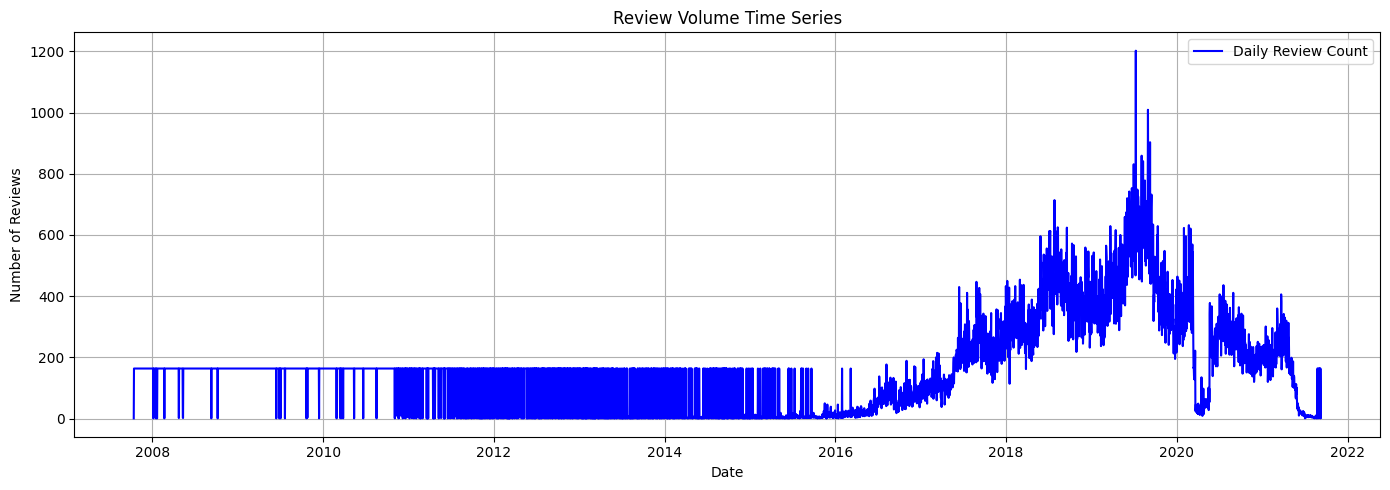

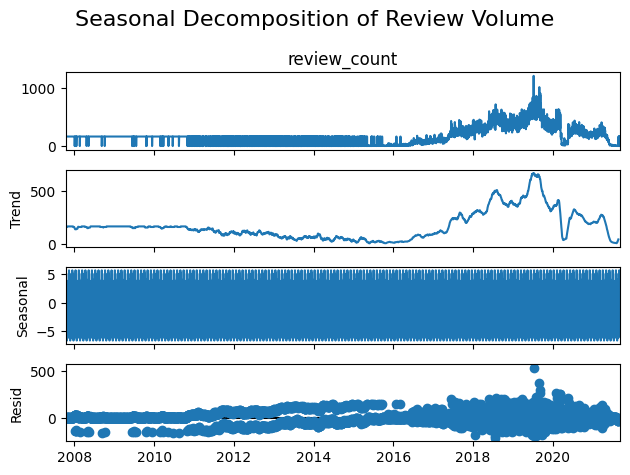

In [35]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#Grouping based on review data
review_counts_per_day = df.groupby(df['newtime'].dt.date).size()
review_counts_per_day.index = pd.to_datetime(review_counts_per_day.index)
review_counts_per_day = review_counts_per_day.rename("review_count")

#Filling the missing value with mean
full_date_range = pd.date_range(start=review_counts_per_day.index.min(),
                                end=review_counts_per_day.index.max(), freq='D')

mean_review_count = review_counts_per_day.mean()
review_counts_filled = review_counts_per_day.reindex(full_date_range, fill_value=mean_review_count)

plt.figure(figsize=(14, 5))
plt.plot(review_counts_filled, label='Daily Review Count', color='blue')
plt.title('Review Volume Time Series')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Decomposing to see seasonality
decomposed = seasonal_decompose(review_counts_filled, model='additive', period=30)  # ~monthly cycle

decomposed.plot()
plt.suptitle('Seasonal Decomposition of Review Volume', fontsize=16)
plt.tight_layout()
plt.show()

We retrieved the newtime data and categorized reviews by day to look at review activity over time.  A time series was created by filling in the missing dates with the average number of daily reviews.  According to the seasonal decomposition, reviews clearly increased between 2015 and 2019 before declining after 2020.  There were small seasonal variations, but noticeable.

Using seasonal_decompose is a relatively easy and simple method to understand trends and seasonality. Any missing values were replaced by the mean. Another way that this could have been solved is by using methods such as STL or ARIMA. The solution we have chosen may not be the optimal one since there is a chance that patterns could be oversimplified. However, it does provide a clear insight and therefore, is useful. 